# Introduction to Cloud Machine Learning with Flask API and CNTK

One of the best ways to operationalize a machine learning system is through an API. [Flask](http://flask.pocoo.org/) is one of the most popular framewoks to develop APIs in python. 

<p style="center;">
<img src="https://miguelgfierro.com/img/upload/2017/04/10/api_overview_350.png" />
</p>

In [14]:
#load libraries
import os,sys
import pkg_resources
from flask import Flask, render_template, request, send_file
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import wget
import numpy as np
from PIL import Image, ImageOps
from urllib.request import urlretrieve
import requests
from cntk import load_model, combine
from io import BytesIO, StringIO
import base64
from IPython.core.display import display, HTML
import aiohttp
import asyncio
import json

print("System version: {}".format(sys.version))
print("Flask version: {}".format(pkg_resources.get_distribution("flask").version))
print("CNTK version: {}".format(pkg_resources.get_distribution("cntk").version))

System version: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Flask version: 0.10.1
CNTK version: 2.0.beta11.0


## Image classification with a pretrained CNTK model
The model is a ResNet with 18 layers, but there are other models that you can try.

In [ ]:
def maybe_download_model(filename='ResNet_18.model'):
    if(os.path.isfile(filename)):
        print("Model %s already downloaded" % filename)
    else:
        model_name_to_url = {
        'AlexNet.model':   'https://www.cntk.ai/Models/AlexNet/AlexNet.model',
        'AlexNetBS.model': 'https://www.cntk.ai/Models/AlexNet/AlexNetBS.model',
        'ResNet_18.model': 'https://www.cntk.ai/Models/ResNet/ResNet_18.model',
        'ResNet_152.model': 'https://migonzastorage.blob.core.windows.net/deep-learning/models/cntk/imagenet/ResNet_152.model'
        }
        url = model_name_to_url[filename] #TODO: try/except in case incorrect filename
        wget.download(url)

In [ ]:
model_name = 'ResNet_152.model'
maybe_download_model(model_name)

In [ ]:
def read_synsets(filename='synsets.txt'):
    with open(filename, 'r') as f:
        synsets = [l.rstrip() for l in f]
        labels = [" ".join(l.split(" ")[1:]) for l in synsets]
    return labels

labels = read_synsets()
print("Label length: ", len(labels))


Let's read images with PIL, plot them and crop them to the ImageNet size: `224x224`.

In [15]:
def read_image_from_file(filename):
    img = Image.open(filename)
    return img
def read_image_from_ioreader(image_request):
    img = Image.open(BytesIO(image_request.read())).convert('RGB')
    return img
def read_image_from_request_base64(image_base64):
    img = Image.open(BytesIO(base64.b64decode(image_base64)))
    return img
def read_image_from_url(url):
    img = Image.open(requests.get(url, stream=True).raw)
    return img

In [3]:
def plot_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
imagepath = 'neko.jpg'
img = read_image_from_file(imagepath)
plot_image(img)

In [ ]:
imagefile = open(imagepath, 'rb')
print(type(imagefile))
img = read_image_from_ioreader(imagefile)
plot_image(img)

In [ ]:
imagefile = open(imagepath, 'rb')
image_base64 = base64.b64encode(imagefile.read())
print("String of %d characters" % len(image_base64))
img = read_image_from_request_base64(image_base64)
plot_image(img)

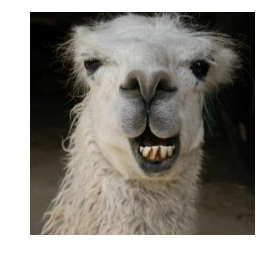

In [16]:
imageurl = 'https://pbs.twimg.com/profile_images/269279233/llama270977_smiling_llama_400x400.jpg'
img2 = read_image_from_url(imageurl)
plot_image(img2)

Once we have the image, the model file and the sysntets, the next step is to load the model and perform a prediction.

In [ ]:
%%time
z = load_model(model_name)

In [17]:
def predict(model, image, labels, number_results = 5):
    #Crop and center the image
    img = ImageOps.fit(image, (224, 224), Image.ANTIALIAS)
    #Transform the image for CNTK format
    img = np.array(img, dtype=np.float32)
    img = np.ascontiguousarray(np.transpose(img, (2, 0, 1)))
    # Use last layer to make prediction
    z_out = combine([model.outputs[3].owner])
    result = np.squeeze(z_out.eval({z_out.arguments[0]:[img]}))
    # Sort probabilities 
    prob_idx = np.argsort(result)[::-1][:number_results]
    pred = [labels[i] for i in prob_idx]
    return pred
 

In [ ]:
resp = predict(z, img, labels, 5)
print(resp)
resp = predict(z, img2, labels, 5)
print(resp)
resp = predict(z, read_image_from_url('http://www.awf.org/sites/default/files/media/gallery/wildlife/Hippo/Hipp_joe.jpg'), labels, 5)
print(resp)

## Set up Flask API

Let´s start the flask server. To do it execute inside a cntk environment:

```bash
source activate my-cntk-env
python cntk_api.py
```

In [50]:
headers = {'Content-type':'application/json'}
data = {'param':'1'}
res = requests.post('http://127.0.0.1:5000/api/v1/classify_image', data=json.dumps(data), headers=headers)
print(res.text)

{
  "error": "Bad request"
}


In [73]:
imageurl = 'https://pbs.twimg.com/profile_images/269279233/llama270977_smiling_llama_400x400.jpg'
data = {'url':imageurl}
res = requests.post('http://127.0.0.1:5000/api/v1/classify_image', data=json.dumps(data), headers=headers)
print(res.text)

{
  "message": [
    "llama",
    "Arabian camel, dromedary, Camelus dromedarius",
    "ostrich, Struthio camelus",
    "Scottish deerhound, deerhound",
    "ram, tup"
  ]
}


In [66]:
imagepath = 'neko.jpg'
image_request = open(imagepath, 'rb')
files_local = {'image': image_request}
#img = read_image_from_ioreader(image_request)
#ret_imgio = BytesIO()
#img.save(ret_imgio, 'PNG')
#files_local = {'image': ret_imgio.getvalue()}


In [67]:
%%time
res = requests.post('http://127.0.0.1:5000/api/v1/classify_image', files=files_local).json()
print(res['message'])

['tabby, tabby cat', 'Egyptian cat', 'tiger cat', 'lynx, catamount', 'shower cap']
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.04 s


## Configure gunicorn

In this tutorial it is explained how to set up gunicorn with flask and nginx [for Ubuntu 14.04](https://www.digitalocean.com/community/tutorials/how-to-serve-flask-applications-with-gunicorn-and-nginx-on-ubuntu-14-04) and [for Ubuntu 16.04](https://www.digitalocean.com/community/tutorials/how-to-serve-flask-applications-with-gunicorn-and-nginx-on-ubuntu-16-04).

Make sure that you install gunicorn inside the `cntk` environment: `pip install gunicorn`. The executable will be available at `/anaconda/envs/cntk/bin/gunicorn`.  

After creating the file [wsgi.py](./wsgi.py), you can start up gunicorn with:
```
/anaconda/envs/cntk/bin/gunicorn --bind 0.0.0.0:8008 wsgi:app
```
You have to get something like this:
```
[2017-03-18 15:40:54 +0000] [35940] [INFO] Starting gunicorn 19.7.0
[2017-03-18 15:40:54 +0000] [35940] [INFO] Listening at: http://0.0.0.0:8008 (35940)
[2017-03-18 15:40:54 +0000] [35940] [INFO] Using worker: sync
[2017-03-18 15:40:54 +0000] [35943] [INFO] Booting worker with pid: 35943
```
Once gunicorn is up, you can test that the endpoint is working. In your browser you can put `http://the-name-of-your-server:8008/`. You should see something like this. 

*NOTE: Make sure that you open the ports of your server. In case you are in an Azure machine, you have to go to your Network security group, then Inbound security rules and then add a new rule with the port 8008.* 


In [6]:
server_name = 'http://the-name-of-your-server'
port = 8008
complete_url = '{}:{}/'.format(server_name, port)
#print("Making a request to: {}".format(complete_url))

In [ ]:
res = requests.get(complete_url)
display(HTML(res.text))

The next step is to configure the file [cntk_api.service](cntk_api.service.template). Depending of your machine you can control the number of workers. You can specify the amount of workers by passing the argument --workers=[n].
```
# (2 Workers * CPU Cores) + 1
# ---------------------------
# For 1 core  -> (2*1)+1 = 3
# For 2 cores -> (2*2)+1 = 5
# For 4 cores -> (2*4)+1 = 9
```
The gunicorn service will create and bind to a Unix socket file within our project directory called `cntk_api.sock`. We'll set a umask value of 007 so that the socket file is created giving access to the owner and group, while restricting other access. Finally, we need to pass in the WSGI entry point file name and the gunicorn executable inside the anaconda environment. 

The next step is to copy the service file to the correct location.

In [ ]:
%%bash 
sudo cp cntk_api.service /etc/systemd/system/


We can now start the Gunicorn service we created and enable it so that it starts at boot.

In [ ]:
%%bash
sudo systemctl start cntk_api
sudo systemctl enable cntk_api



## Configure Nginx

You need to install nginx: `sudo apt-get install nginx -y`. Then you need to update the template [cntk_api.template](cntk_api.template) with the correct values and place it in the nginx sites directory.



In [ ]:
%%bash
sudo cp cntk_api /etc/nginx/sites-available/
sudo ln -s /etc/nginx/sites-available/cntk_api /etc/nginx/sites-enabled

Once the configuration file has been placed in the correct directory, we can test if there is any problem with nginx server. 


In [ ]:
%%bash
sudo nginx -t

Finally, if there are no issues, we need to restart nginx

In [ ]:
%%bash
sudo systemctl restart nginx

The next step is to see if now the API is working through nginx and gunicorn. This time we just need to call the `server_name` without the port. If fact we can close the port 5000. 

In case you get a `502 Bad Gateway`. There are several ways to go. You can visualize the errors of nginx in `/var/log/nginx/error.log`. Another clue is to see the logs of gunicorn service with `sudo journalctl -u cntk_api`. These two commands should help you to solve the problems. More support can be found in the comments of [this tutorial](https://www.digitalocean.com/community/tutorials/how-to-serve-flask-applications-with-gunicorn-and-nginx-on-ubuntu-16-04).

Once the changes are done, you have to restart the gunicorn service and nginx:
```bash
sudo systemctl restart cntk_api
sudo systemctl restart nginx
```

In [ ]:
res = requests.get(server_name)
display(HTML(res.text))

## CNTK API with Nginx and Gunicorn

To see the nginx request logs you have to go to `/var/log/nginx/access.log`. You can also see the gunicorn logs in `debug_gunicorn.log` in the path defined in [cntk_api.service](cntk_api.service).

In [ ]:
imagepath = 'neko.jpg'
image_request = open(imagepath, 'rb')
files = {'image': image_request}
print(files)

In [8]:
end_point = server_name + 'api/v1/classify_image' 
#print(end_point)

In [ ]:
res = requests.post(end_point, files=files).json()
print(res['message'])

## Bombardment
Let's go to the funny part. Now that we have the API set up with nginx and gunicorn, let's test how the system performs under a big number of concurrent resquests.

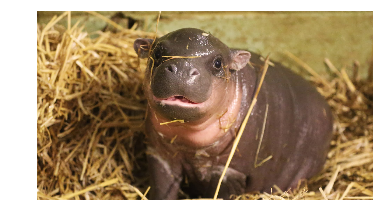

In [4]:
# Get hippo
hippo_url = "https://i.ytimg.com/vi/96xC5JIkIpQ/maxresdefault.jpg"

fname = urlretrieve(hippo_url, "bhippo.jpg")[0]
img_bomb = read_image_from_file(fname)
plot_image(img_bomb)

In [9]:
NUM = 50
concurrent = 10
url_dict = {
    'api_endpoint':end_point
}

In [10]:
# Save same file multiple times in memory as IO
imagefile = open(fname, 'rb')
img = Image.open(BytesIO(imagefile.read())).convert('RGB')
img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)
ret_imgio = BytesIO()
img.save(ret_imgio, 'PNG')

# FOR OTHERS
url_list = [dta for dta in zip(
        [url_dict['api_endpoint']] * NUM,
        [{'image': ret_imgio.getvalue()} for _ in range(NUM)])]



In [11]:
def handle_req(data):
    return json.loads(data.decode('utf-8'))
 
def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)
    @asyncio.coroutine
    # Return co-routine that will work asynchronously and respect
    # locking of semaphore
    
    def http_get(dta):
        nonlocal semaphore
        with (yield from semaphore):
            url, img = dta
            response = yield from s.request('post', url, data=img)
            body = yield from response.content.read()
            yield from response.wait_for_close()
        return body
    return http_get
 
def run_experiment(urls, _session):
    http_client = chunked_http_client(num_chunks=concurrent, s=_session)
    
    # http_client returns futures, save all the futures to a list
    tasks = [http_client(url) for url in urls]
    dfs_route = []
    
    # wait for futures to be ready then iterate over them
    for future in asyncio.as_completed(tasks):
        data = yield from future
        try:
            out = handle_req(data)
            dfs_route.append(out)
        except Exception as err:
            print("Error {0}".format(err))
    return dfs_route

In [12]:
%%time
# Expect to see some 'errors' meaning requests are expiring on 'queue'
# i.e. we can't increase concurrency any more
with aiohttp.ClientSession() as session:  # We create a persistent connection
    loop = asyncio.get_event_loop()
    complete_responses = loop.run_until_complete(run_experiment(url_list, session)) 

Creating a client session outside of coroutine
client_session: <aiohttp.client.ClientSession object at 0x7f17b0f909e8>


Error Expecting value: line 1 column 1 (char 0)
Error Expecting value: line 1 column 1 (char 0)
CPU times: user 92 ms, sys: 12 ms, total: 104 ms
Wall time: 1min 32s


In [13]:
print(len(complete_responses))
print(complete_responses[:5])
# Successful responses
complete_responses.count(complete_responses[1])

48
[{'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'Staffordshire bullterrier, Staffordshire bull terrier', 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 'bullfrog, Rana catesbeiana', 'cricket']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'Staffordshire bullterrier, Staffordshire bull terrier', 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 'bullfrog, Rana catesbeiana', 'cricket']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'Staffordshire bullterrier, Staffordshire bull terrier', 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 'bullfrog, Rana catesbeiana', 'cricket']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'Staffordshire bullterrier, Staffordshire bull terrier', 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 'bullfrog, Rana catesbeiana', 'cricket']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus

48

## Final remarks
